In [ ]:
# DS776 Auto-Update (runs in ~2 seconds, only updates when needed)
# If this cell fails, see Lessons/Course_Tools/AUTO_UPDATE_SYSTEM.md for help
%run ../Course_Tools/auto_update_introdl.py

In [ ]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
import torch

# Use introdl's Trainer for smart caching with pretend_train
from introdl import (
    Trainer,
    get_device,
    wrap_print_text,
    config_paths_keys,
    llm_generate,
    show_session_spending
)

# Import helper function for LLM classification
from Lesson_08_Helpers import llm_classifier

print = wrap_print_text(print)

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

# for just this lesson LESSON_DATA will point to the dataset we use throughout
LESSON_DATA = Path('./data').resolve() / 'IT_tickets_classify.csv'

## Text Classification

**Note:**  It's important to read Chapter 2 in our NLP book in addition to this notebook.  Many things like tokenization and model architecture aren't discussed in the notebook.  

The field of text classification has been completely revolutionized since the invention of transformer models in 2017.  I asked ChatGPT for a brief history of state-of-the-art approaches.  After a bit of refinement here's what it had to say:

(if nothing else, read the headers and short descriptions ...)

### **Chronology of State-of-the-Art Approaches for Text Classification**  

This timeline provides an overview of major advancements in text classification, from traditional machine learning models using Bag-of-Words and TF-IDF to modern transformer-based models like BERT and GPT.

---

### **Pre-2010s: Traditional ML with TF-IDF and Bag-of-Words**  
Before deep learning, text classification relied on statistical and machine learning approaches that used **Bag-of-Words (BoW)** and **TF-IDF** features. Popular classifiers included **Naïve Bayes, Support Vector Machines (SVMs), and Decision Trees**, which performed well despite ignoring word order and meaning.

- **1990s–Early 2000s**: Classical machine learning algorithms were widely used with simple BoW and TF-IDF feature representations.
- **2003–2010**: Topic modeling techniques like **Latent Semantic Analysis (LSA)** and **Latent Dirichlet Allocation (LDA)** emerged, helping with dimensionality reduction and improving classification performance.

---

### **2010s: Word Embeddings and Deep Learning**  
Fixed word embeddings, such as **Word2Vec** and **GloVe**, improved text representations by capturing word relationships in continuous vector spaces. Deep learning architectures like **CNNs and RNNs (LSTMs, GRUs)** further enhanced classification by learning sequential patterns in text.

- **2013**: **Word2Vec (Mikolov et al.)** introduced dense word embeddings, significantly improving text classification features over TF-IDF.
- **2014**: **GloVe (Pennington et al.)** refined word embeddings using word co-occurrence statistics, outperforming Word2Vec in some tasks.
- **2014–2015**: **CNNs for text classification** (e.g., Kim 2014) and **Recurrent Neural Networks (RNNs) with LSTMs/GRUs** became widely adopted.
- **2015–2016**: **Attention mechanisms** (Bahdanau et al. 2015) improved RNNs by helping models focus on important words in a sentence.

---

### **Late 2010s: Pretrained Contextual Embeddings and Transfer Learning**  
Contextual word embeddings and transformer architectures introduced a paradigm shift in text classification by learning rich, bidirectional word representations.

- **2018**: **ELMo (Peters et al.)** introduced deep contextualized embeddings, capturing word meaning based on sentence context.
- **2018**: **BERT (Devlin et al.)** revolutionized NLP by leveraging masked language modeling and bidirectional transformers to significantly improve classification accuracy.
- **2019**: **DistilBERT (Sanh et al.)** was introduced as a smaller, faster version of BERT, making transformer-based fine-tuning more efficient.

---

### **2020s: Transformer Fine-Tuning and Large Language Models (LLMs)**  
Modern NLP models rely on large-scale transformers trained on massive datasets. These models often perform well with minimal fine-tuning and even excel in zero-shot or few-shot classification tasks.

- **2020**: **RoBERTa (Liu et al.)**, **ALBERT (Lan et al.)**, and **XLNet (Yang et al.)** improved transformer-based models for classification by optimizing training techniques and model architecture.
- **2021–2023**: **GPT-3 and ChatGPT** demonstrated strong zero-shot and few-shot classification abilities, reducing the need for supervised fine-tuning.
- **2024–Present**: **LLMs like GPT-4 and fine-tuned versions (e.g., GPT-4-turbo, Mistral, Llama)** dominate text classification, often replacing traditional ML and deep learning approaches.

---


## Classifying Technical Support Requests Example

In this notebook we'll demonstrate and compare three approaches for text classification.  As an example we'll classify technical support help requests into categories using a dataset downloaded from Kaggle.  Briefly, here are the three approaches we'll use:

1.  A "pre-2010s" technique where statstical analysis of the help requests is used to create vectors containing information about the frequencies of words in the documents.  Those vectors are used as feature vectors for a typical machine learning classifier like logistic regression.

2. A "2020s" technique where we fine-tune a pre-trained transformer classification model.

3. An LLM-based approach with zero-shot and few-shot prompts.

Our goal is to build an automated classifier that can be used to send support tickets to appropriate technical support staff.


#### L08_1_IT_Tickets_Dataset Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_it_tickets_dataset/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_it_tickets_dataset/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/5QHjGH5l6rC" target="_blank">Open Descript version of video in new tab</a>

### Load and Visualize Data

This dataset is a public domain dataset found on Kaggle called ["IT Service Ticket Classification Dataset"](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset).  We'll included the csv file in the data subdirectory along in the same directory as this notebook.  

The data includes 47,837 help requests and their classifications into 8 categories: 'Hardware', 'HR Support', 'Access', 'Miscellaneous', 'Storage', 'Purchase', 'Internal Project', 'Administrative rights'.

Let's load the data and explore it a bit.



In [2]:
df = pd.read_csv(LESSON_DATA)

print(f'This dataset has {df.shape[0]} IT tickets')

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

This dataset has 47837 IT tickets


Print the first few rows to get a sense of the data:

In [3]:
df.head(10)

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous
5,mail please dear looks blacklisted receiving m...,Miscellaneous
6,prod servers tunneling prod tunneling va la tu...,Hardware
7,access request dear modules report report cost...,HR Support
8,reset passwords for our client and passwords c...,Access
9,direct reports missing time please action repo...,HR Support


Let's look at the distribution of the labels to geta sense of whether the dataset is balanced.  We can also see how long the help reequsts are.

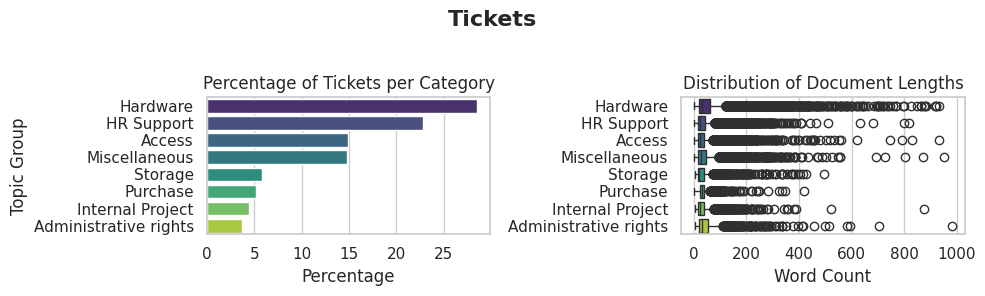

In [4]:
# Calculate percentages per category
category_counts = df["Topic_group"].value_counts(normalize=True) * 100
category_percentages = category_counts.reset_index()
category_percentages.columns = ["Topic_group", "Percentage"]

# Calculate lengths of documents as word count
df["Document_Length"] = df["Document"].apply(lambda x: len(x.split()))

# Get the order of categories from the barplot data
category_order = category_percentages["Topic_group"]

# Create a consistent color palette
palette = sns.color_palette("viridis", len(category_order))
color_mapping = dict(zip(category_order, palette))

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Barplot: Percentage per category
sns.barplot(
    data=category_percentages,
    x="Percentage",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[0]
)
axes[0].set_title("Percentage of Tickets per Category")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("Topic Group")

# Boxplot: Distribution of document lengths
sns.boxplot(
    data=df,
    x="Document_Length",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[1]
)
axes[1].set_title("Distribution of Document Lengths")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("")

# Set the suptitle
fig.suptitle("Tickets", fontsize=16, weight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The distribution of labels shows that the dataset is moderately imbalanced with a ration of the smallest class frequency to the largest class frequency of about 4:28 or 1:7.  We'll look at the classification report to see if imbalance is creating an issue.  

Nearly all of the help requests are about 100 words or less with only outliers having greater lengths.

### Prepare the data

Split the data and build mappings from text labels to integer labels and vice versa.

In [5]:
test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = list(set(train_labels_str + test_labels_str))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]



---

## Approach 1: Create Statistical Embedding Vectors and Apply Standard ML

#### L08_1_TFIDF_Plus_Logistic_Regression Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_tfidf_plus_logistic_regression/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_tfidf_plus_logistic_regression/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/CE1TdBdDw4s" target="_blank">Open Descript version of video in new tab</a>


We're going to create TF-IDF vectors to represent each help request.  Then we'll use those TF-IDF vectors to train and test a logistic regression classifier.

### What Are TF-IDF Vectors?

TF-IDF (Term Frequency-Inverse Document Frequency) vectors are a statistical representation of text data that capture the importance of terms within a document relative to a collection of documents (the corpus). This method assigns a weight to each term based on its frequency in a specific document (term frequency, TF) and how common or rare it is across all documents in the corpus (inverse document frequency, IDF). The result is a sparse, numerical vector for each document, where each dimension corresponds to a unique term in the vocabulary. TF-IDF is widely used in text mining, natural language processing, and machine learning as a feature extraction technique for tasks like classification, clustering, and information retrieval. However, as the size of the vocabulary grows, the dimensionality of the TF-IDF vectors increases, potentially leading to computational inefficiencies and the curse of dimensionality.

---

### Tricks for Limiting Dimensionality

To address the high dimensionality of TF-IDF vectors, several preprocessing techniques can be applied to reduce the vocabulary size while retaining the most meaningful terms. **Stemming** is one such method, where words are reduced to their root forms (e.g., "running" → "run"), grouping related words into a single term and thereby reducing the vocabulary size. Similarly, **lemmatization** refines this process by considering the context and part of speech to produce base forms. Removing **stopwords** like "the," "is," and "and" eliminates common, less informative terms that appear frequently across documents. Setting thresholds for **minimum and maximum document frequency** (e.g., `min_df` and `max_df`) ensures that terms appearing in very few documents or nearly all documents are excluded from the vocabulary. Additionally, limiting the vocabulary size directly with `max_features` retains only the top terms with the highest importance scores. Finally, incorporating **n-grams** (e.g., bigrams and trigrams) helps capture multi-word phrases, adding context while keeping the range limited to prevent explosive growth in dimensionality. Combining these techniques creates a more compact, computationally efficient representation of text data while preserving its semantic richness.

### Building the vectors

We'll use the TfidfVectorizer from sci-kit learn.  Here we're telling it to ignore common English stop words - words like "the", "end", "to" that carry little meaningful information on their own.  We're also telling the vectorizer to consider one-, two-, or three- word sequences (ngrams) as entries in the vocabulary so that "ball" and "big red ball" could be distinct.


In [6]:

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English stopwords
    min_df=2,  # Remove rare terms (appear in fewer than 2 documents)
    max_df=0.85,  # Remove overly common terms (appear in more than 85% of documents)
    max_features=1000,  # Limit vocabulary size to top 1000 terms
    ngram_range=(1, 3)  # Include unigrams, bigrams, and trigrams
)

# Fit the vectorizer and transform the input texts
train_features_tfidf = tfidf_vectorizer.fit_transform(train_texts_str)
test_features_tfidf = tfidf_vectorizer.transform(test_texts_str)

We can see below that the vectors for train_features are stored in a sparse array with 38,269 rows and 1000 columns.  Those 38,269 rows represent all help requests in teh training data.  The vectors have dimension 1000 because that's the size of the vocabulary we allowed.

In [7]:
train_features_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 873248 stored elements and shape (38269, 1000)>

Now we fit a logistic regression model using scikit-learn and make predictions for the test data.  We also produce a confusion matrix and a classification report.

Classification Report:
                       precision    recall  f1-score   support

               Access       0.92      0.87      0.89      1455
Administrative rights       0.84      0.70      0.76       342
           HR Support       0.84      0.83      0.84      2107
             Hardware       0.79      0.87      0.83      2760
     Internal Project       0.89      0.79      0.84       451
        Miscellaneous       0.80      0.82      0.81      1400
             Purchase       0.96      0.88      0.92       497
              Storage       0.92      0.85      0.89       556

             accuracy                           0.84      9568
            macro avg       0.87      0.82      0.85      9568
         weighted avg       0.85      0.84      0.84      9568



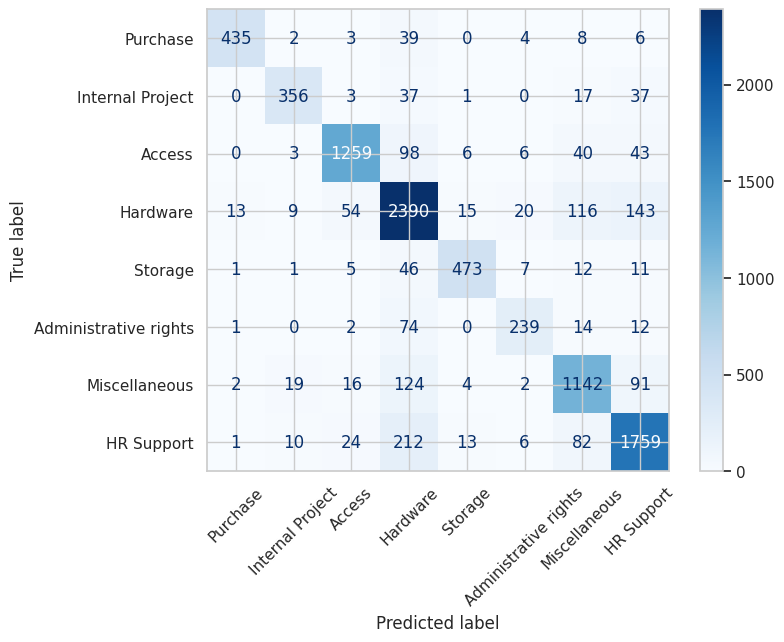

In [8]:
# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_features_tfidf, train_ids)

# Make predictions on the test set
test_predictions_id = model.predict(test_features_tfidf)

# Convert integer labels to string labels for the test set and predictions
test_predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, test_predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, test_predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": test_predictions_str
})

Overall, the model does well with 84% overall accuracy.  The smallest class, "Administrative Rights" is underpredicted.  The precision for that class is 84% suggesting the model is usually right when it predicts "Administrative Rights", but the recall is only 70% meaning that the model misses many instances of this class (it underpredicts).

We can try to correct for the imbalance in the date to see if how that changes the overall results.  A simple way to do that is to tell the logistic regression model to use balanced class weights to put more weight on the minority classes.

Classification Report:
                       precision    recall  f1-score   support

               Access       0.90      0.88      0.89      1455
Administrative rights       0.58      0.90      0.71       342
           HR Support       0.86      0.80      0.83      2107
             Hardware       0.86      0.75      0.80      2760
     Internal Project       0.76      0.93      0.84       451
        Miscellaneous       0.76      0.85      0.80      1400
             Purchase       0.88      0.91      0.90       497
              Storage       0.83      0.92      0.88       556

             accuracy                           0.83      9568
            macro avg       0.81      0.87      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



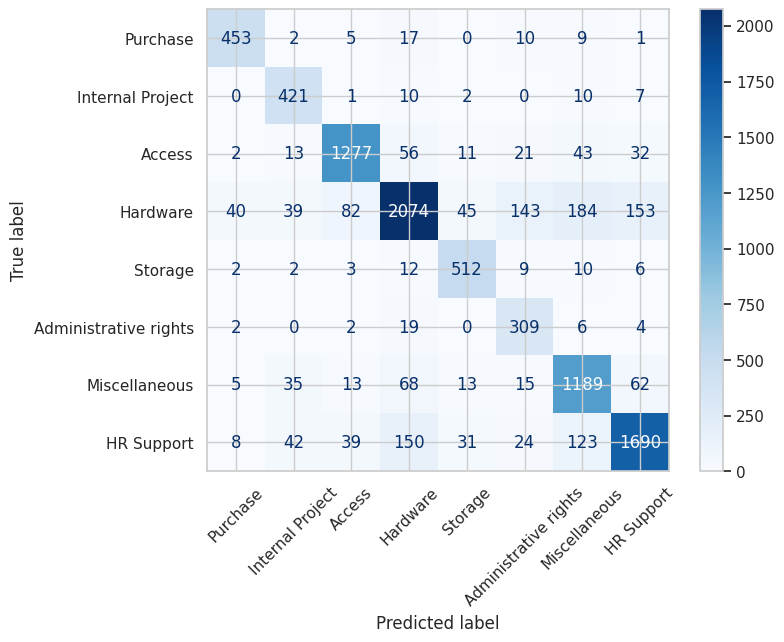

In [9]:
# Initialize and fit the logistic regression model
model = LogisticRegression(class_weight = 'balanced', max_iter=1000, random_state=42)
model.fit(train_features_tfidf, train_ids)

# Make predictions on the test set
test_predictions_id = model.predict(test_features_tfidf)

# Convert integer labels to string labels for the test set and predictions
test_predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, test_predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, test_predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": test_predictions_str
})

Now the overall accuracy is 83%.  In correcting for the imbalance in the data, the model is now overpredicting the minority "Administrative Rights" class.  You could choose one of those two models depending on which error is more tolerable, you could look for another way to address the data imbalance, or you could look for another modeling approach as we'll do in the next section.

## Approach 2: Using a Transfomer Model to Extract Features for a Standard ML Model



#### L08_1_Transformer_Features_Plus_ML Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_transformer_features_plus_ml/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_transformer_features_plus_ml/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/TzM8eTa3x0u" target="_blank">Open Descript version of video in new tab</a>


In this section we'll mimic what the textbook did, but using our IT service requests dataset to see how it compares to other approaches.

### Using Distilbert to Extract Features for Logistic Regression

In this approach we use a Distilbert model thas has been pre-trained on the mask-filling task to extract a feature vector for each help request.  The feature extraction in this approach is much slower than the previous approach since it involves a forward call of the model.  A GPU helps, but the computation needs to be done in batches unless your GPU has a lot of vRAM.  

The cell below for loading and splitting the data is the same as the in the first section but is here for convenience.  

In [10]:
# repeat of code from above for convenience

df = pd.read_csv(LESSON_DATA)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = list(set(train_labels_str + test_labels_str))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]


Now we tokenize the datasets, which means converting the words or subwords to integers according to their position in a vocabulary definied in the tokenizer.

In [11]:
# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Set a padding token (use an existing one or define a new one)
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size

# Check for GPU
device = get_device()
print(f"Using device: {device}")

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

# Tokenize datasets
train_tokenized = tokenize_dataset(tokenizer, train_texts_str, train_ids)
test_tokenized = tokenize_dataset(tokenizer, test_texts_str, test_ids)



Using device: cuda


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

The cell below took about 70 seconds on a high-end NVIDIA gaming GPU.

In [12]:
# Load the pre-trained DistilBERT model
model = AutoModel.from_pretrained(model_checkpoint)
model.to(device)

# Extract features for train and test sets in batches using tokenized datasets
def extract_features_from_tokenized(tokenized_dataset, model, device, batch_size=100):
    """Extract features from tokenized dataset using DistilBERT in batches."""
    features = []
    for i in range(0, len(tokenized_dataset), batch_size):
        batch = tokenized_dataset[i:i + batch_size]
        inputs = {key: torch.tensor(value).to(device) for key, value in batch.items() if key in ["input_ids", "attention_mask"]}
        with torch.no_grad():
            outputs = model(**inputs)
        batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)
    return np.vstack(features)

# Extract features for train and test sets
train_features_bert = extract_features_from_tokenized(train_tokenized, model, device)
test_features_bert = extract_features_from_tokenized(test_tokenized, model, device)

To fit a logistic regression model using these feature vectors, they need to be rescaled or the logistic regression model training may have trouble converging.  You can read more about [feature scaling here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py).

Classification Report:
                       precision    recall  f1-score   support

               Access       0.79      0.79      0.79      1455
Administrative rights       0.67      0.61      0.64       342
           HR Support       0.75      0.75      0.75      2107
             Hardware       0.75      0.76      0.75      2760
     Internal Project       0.77      0.70      0.73       451
        Miscellaneous       0.68      0.69      0.69      1400
             Purchase       0.88      0.86      0.87       497
              Storage       0.78      0.79      0.78       556

             accuracy                           0.75      9568
            macro avg       0.76      0.74      0.75      9568
         weighted avg       0.75      0.75      0.75      9568



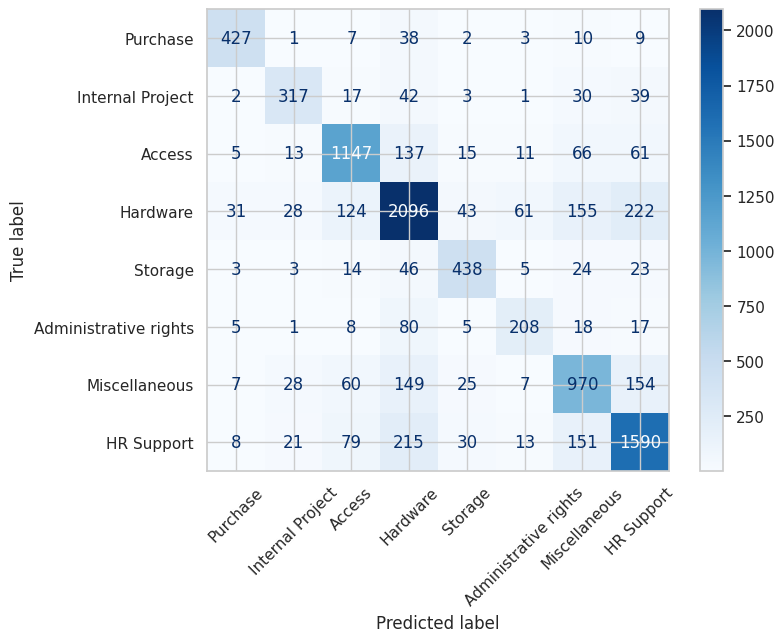

In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training features and transform both train and test features
train_features_bert = scaler.fit_transform(train_features_bert)
test_features_bert = scaler.transform(test_features_bert)

# Train logistic regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(train_features_bert, train_ids)

# Make predictions on the test set
test_predictions_id = log_reg_model.predict(test_features_bert)

# Convert integer labels to string labels for the test set and predictions
predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

This model performed worse than the model using TF-IDF vectors.  For this dataset the TF-IDF approach does rather well, but we'll see in the next section that even a complete small transformer model like Distilbert will perform better.  

## Approach 3: Fine-Tuning a Transformer Model Including a Classifier


#### L08_1_Transfomer_Fine-Tuning Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_transfomer_fine-tuning/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_transfomer_fine-tuning/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/Ego6IgU2Jnh" target="_blank">Open Descript version of video in new tab</a>



Now, instead of freezing the backbone and using it to extract features, we're going to add a newly initialized classification head and fine-tune the whole model for two epochs.  This allows the feature vectors to adapt to the dataset a little and for the classification head to leverage this information to improve the predictions.  We'll use a the same pretrained Distilbert model as in the previous section.

We include the data preparation again here for convenience:


In [14]:
# repeat of code from above for convenience

df = pd.read_csv(LESSON_DATA)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = list(set(train_labels_str + test_labels_str))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]


In [15]:
# repeated from above for convenience

# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Set a padding token (use an existing one or define a new one)
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size

# Check for GPU
device = get_device()
print(f"Using device: {device}")

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

# Tokenize datasets
train_tokenized = tokenize_dataset(tokenizer, train_texts_str, train_ids)
test_tokenized = tokenize_dataset(tokenizer, test_texts_str, test_ids)

Using device: cuda


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]


The fine-tuning took about 20 minutes on my gaming GPU.  You'll work with a smaller dataset in the homework.

In [ ]:
batch_size = 32  # Reduce if memory issues

models_and_logs_dir = MODELS_PATH / 'L08_fine_tune_distilbert'

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_to_id))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=models_and_logs_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01, # Regularization to prevent overfitting
    bf16=True,  # Automatically uses BF16 if GPU supports it (lower precision for speed and memory)
    logging_dir=models_and_logs_dir / "logs",
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="eval_accuracy",
    save_total_limit=1, # Keep only the best model
    logging_strategy="epoch",
    disable_tqdm=False # should default to False, but seems necessary to set to False to see progress bar
)

def compute_metrics(pred):
    """Compute evaluation metrics."""
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"eval_accuracy": acc, "eval_f1": f1, "eval_precision": precision, "eval_recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    pretend_train=True  # Enable smart caching - loads existing model if available
)

output = trainer.train()

# Note: Model is automatically saved to best_model/ directory by TrainerWithPretend

Now we'll make predictions with our newly fine-tuned model and build a classification report.

In [21]:
predictions = trainer.predict(test_tokenized)

y_true_id = predictions.label_ids
y_pred_id = np.argmax(predictions.predictions, axis=1)

test_labels_str = [id_to_label[label] for label in y_true_id]
predictions_str = [id_to_label[label] for label in y_pred_id]

print("Classification Report:")
print(classification_report(y_true_id, y_pred_id, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

     Internal Project       0.91      0.88      0.90       451
           HR Support       0.88      0.90      0.89      2107
             Purchase       0.96      0.90      0.93       497
              Storage       0.89      0.92      0.90       556
        Miscellaneous       0.86      0.86      0.86      1400
             Hardware       0.88      0.88      0.88      2760
Administrative rights       0.86      0.78      0.82       342
               Access       0.91      0.93      0.92      1455

             accuracy                           0.89      9568
            macro avg       0.89      0.88      0.89      9568
         weighted avg       0.89      0.89      0.89      9568



We can see that the overall accuracy has improved to about 89%.  Moreover, the imbalanced data seems to be less of an issue since the precision and recall for the smallest and largest classes are more similar than they were before.  The model does seem to be underpredicting Administrative Rights a little, but is still improved over the previous models.  It may continue to improve by fine-tuning for another epoch or two.

In [ ]:
# Step 1: Load the fine-tuned model and tokenizer from the best_model directory
best_model_path = models_and_logs_dir / "best_model"

print(f"Loading model from: {best_model_path}")
loaded_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(best_model_path)
loaded_model.to(device)
print("✓ Model loaded successfully!\n")

# Step 2: Create some new example support requests to classify
new_support_requests = [
    "My laptop screen is flickering and showing strange colors. Can someone help?",
    "I need to purchase 3 new monitors for our team. How do I submit a purchase order?",
    "Can you please give me admin access to the database server?",
    "My mailbox is full and I can't send emails anymore. Please increase my storage quota.",
    "We need to onboard a new employee starting Monday. Please create their account.",
]

print("New Support Requests to Classify:")
for i, request in enumerate(new_support_requests, 1):
    print(f"{i}. {request}")
print()

# Step 3: Tokenize the new requests
inputs = loaded_tokenizer(
    new_support_requests, 
    padding=True, 
    truncation=True, 
    max_length=512, 
    return_tensors="pt"
).to(device)

# Step 4: Make predictions
with torch.no_grad():
    outputs = loaded_model(**inputs)
    logits = outputs.logits
    predicted_class_ids = torch.argmax(logits, dim=1).cpu().numpy()

# Step 5: Convert predicted IDs back to label names
predicted_labels = [id_to_label[class_id] for class_id in predicted_class_ids]

# Step 6: Display predictions
print("\nPredictions:")
print("-" * 80)
for i, (request, label) in enumerate(zip(new_support_requests, predicted_labels), 1):
    print(f"{i}. Request: {request}")
    print(f"   Predicted Category: {label}\n")

# Step 7: Show confidence scores for the first example
print("\nDetailed Analysis for First Request:")
print(f"Request: {new_support_requests[0]}")
print(f"\nConfidence Scores by Category:")

# Get probabilities using softmax
probabilities = torch.nn.functional.softmax(logits[0], dim=0).cpu().numpy()

# Create a DataFrame for better visualization
confidence_df = pd.DataFrame({
    'Category': [id_to_label[i] for i in range(len(id_to_label))],
    'Confidence': probabilities
})
confidence_df = confidence_df.sort_values('Confidence', ascending=False)
confidence_df['Confidence'] = confidence_df['Confidence'].apply(lambda x: f"{x:.4f}")

display(confidence_df.reset_index(drop=True))

### Loading a Pretrained Model for Inference

One of the most important skills in deep learning is knowing how to load and use a trained model for making predictions on new data. This is essential for:
- Deploying models in production applications
- Making predictions across multiple sessions without retraining
- Sharing models with others (via HuggingFace Hub or local files)
- Testing model performance on new datasets

In this section, we'll demonstrate how to:
1. Load a previously fine-tuned model from disk
2. Use it to make predictions on new support requests
3. Interpret the model's outputs

**Note:** When using `pretend_train=True`, the model is automatically loaded if it exists. But for real-world inference (like in a deployed application), you'll typically load the model separately without the training infrastructure.

In [ ]:
# Get training history as a DataFrame
history_df = trainer.get_training_history()

# Display the full history
print("Training History:")
display(history_df)

# Create plots to visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], 'o-', label='Train Loss', color='blue')
axes[0, 0].plot(history_df['epoch'], history_df['eval_loss'], 's-', label='Eval Loss', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[0, 1].plot(history_df['epoch'], history_df['eval_accuracy'], 'o-', label='Accuracy', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1 Score
axes[1, 0].plot(history_df['epoch'], history_df['eval_f1'], 'o-', label='F1 Score', color='purple')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Precision and Recall
axes[1, 1].plot(history_df['epoch'], history_df['eval_precision'], 'o-', label='Precision', color='red')
axes[1, 1].plot(history_df['epoch'], history_df['eval_recall'], 's-', label='Recall', color='cyan')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Validation Precision and Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find and display best epoch metrics
best_idx = history_df['eval_accuracy'].idxmax()
print(f"\nBest Model Performance:")
print(f"  Epoch: {history_df.loc[best_idx, 'epoch']:.0f}")
print(f"  Accuracy: {history_df.loc[best_idx, 'eval_accuracy']:.4f}")
print(f"  F1 Score: {history_df.loc[best_idx, 'eval_f1']:.4f}")
print(f"  Precision: {history_df.loc[best_idx, 'eval_precision']:.4f}")
print(f"  Recall: {history_df.loc[best_idx, 'eval_recall']:.4f}")

### Accessing Training Metrics Programmatically

When using `pretend_train=True`, the training metrics are automatically displayed when loading a pre-trained model. However, you can also access them programmatically for further analysis or visualization.

The `get_training_history()` method returns a pandas DataFrame containing all the training metrics (training loss, validation loss, accuracy, F1, precision, recall) for each epoch. This is useful for:
- Creating custom plots of training progress
- Comparing metrics across different training runs
- Analyzing model convergence and overfitting
- Reporting best epoch performance

Let's see how to access and visualize these metrics:

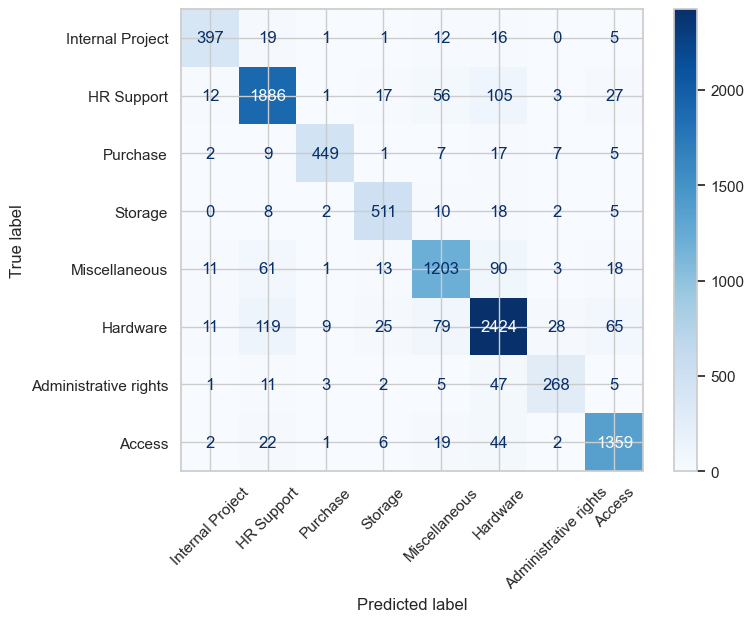

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_label.values()))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()


## Approach 4: Use an LLM and prompting for Classification


#### L08_1_LLM_Classification Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_llm_classification/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_llm_classification/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/WY8FXinVXAz" target="_blank">Open Descript version of video in new tab</a>



Here we'll demonstrate how to use an LLM with zero-shot prompting.  Zero-shot means we're not providing any classification examples in our prompt.  Instead, we specify the possible labels and additional instructions and let the an LLM try to sort it out!

We wouldn't normally use an LLM here since we have plenty of data for fine-tuning, but let's see what an LLM can do as an example.

We'll first use one of our local models, but you could substitute an open-source model from Groq or Together.AI here if you like.

In [ ]:
# For this lesson, we'll use OpenRouter models with llm_generate()
# Some recommended models for classification tasks:
# - 'gemini-flash-lite' - Fast, cost-effective (Google)
# - 'gpt-4o-mini' - Good balance of speed and quality (OpenAI)
# - 'llama-3.3-70b' - Strong open-source model (Meta)
# - 'mistral-medium' - Balanced performance (Mistral)

# We'll start with Gemini Flash Lite for its speed and low cost
LLM_MODEL = 'gemini-flash-lite'
print(f"Using model: {LLM_MODEL}")

# No model loading needed! OpenRouter models are accessed via API.
# llm_generate() and llm_classifier() will handle the API calls automatically.

We've built a helper function for using our selected LLM as a classifier.  We'll talk about it a bit in our video and show how to use it via an example.

**Using the `llm_classifier()` Helper Function**

We've created a helper function `llm_classifier()` (imported from Lesson_08_Helpers.py) that simplifies using LLMs for classification tasks. 

The function:
- Takes a model name (e.g., 'gemini-flash-lite') instead of a config object
- Builds user prompts from your template
- Calls `llm_generate()` with appropriate parameters
- Returns predicted labels

**Key Parameters:**
- `model_name`: OpenRouter model name (or any OpenAI-compatible model with api_key/base_url)
- `texts`: List of documents to classify
- `system_prompt`: Instructions for the LLM
- `prompt_template`: Template with {text} placeholder
- `temperature`: 0 for deterministic (default), higher for creativity
- `estimate_cost`: True to see API cost estimates
- `api_key`, `base_url`: Optional for non-OpenRouter providers

We'll demonstrate its use in the examples below.

In [4]:
# repeat of code from above for convenience

data_path = Path('./data/IT_tickets_classify.csv').resolve() 
df = pd.read_csv(data_path)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = list(set(train_labels_str + test_labels_str))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]


It's a good idea to experiment with a small number of examples to refine your prompts.  It can be difficult to get an LLM to produce the exact output you want so you often need to be very directed in your prompts. 

In the next cell we try to classify the first 10 requests in the test set.  (I spent a while playing here to try to get the LLM to produce only the desired labels.  You'll see in the next cell that it's far from good at this.)

In [ ]:
N = 10
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

# Use OpenRouter with Gemini Flash Lite (fast and cost-effective)
predictions = llm_classifier(LLM_MODEL, texts, system_prompt, prompt_template)

for i in range(N):
    print(f"Support Request: {texts[i]}\n")
    print(f"Predicted Label: {predictions[i]}, Actual Label: {labels[i]}")
    print("-----------------------------------------------\n")

Now let's apply the LLM to 100 examples to compile some statistics about its performance. Since we're using such a small subset the statistics won't be very precise, but they'll be enough to get an idea about this approach.  This took a couple of minutes with my gaming GPU.

In [ ]:
N = 10
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

# Use OpenRouter with Gemini Flash Lite (fast and cost-effective)
predictions = llm_classifier(LLM_MODEL, texts, system_prompt, prompt_template)

for i in range(N):
    print(f"Support Request: {texts[i]}\n")
    print(f"Predicted Label: {predictions[i]}, Actual Label: {labels[i]}")
    print("-----------------------------------------------\n")

Even with a detailed prompt the LLM can sometimes make predictions other than the specified labels. We can use a python set to ignore duplicates for seeing all the unique labels.  With the llama model we  get only the desired labels.  We tried for a while to get the Mistral model to work, but couldn't get it to only use the desired labels

In [ ]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

# Use OpenRouter with Gemini Flash Lite, showing cost estimate
predictions = llm_classifier(LLM_MODEL, texts, system_prompt, prompt_template, estimate_cost=True)

In [30]:
print("Classification Report:")
print(classification_report(labels, predictions, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

     Internal Project       0.30      0.27      0.29        11
           HR Support       0.00      0.00      0.00         4
             Purchase       0.00      0.00      0.00        22
              Storage       0.78      0.24      0.37        29
        Miscellaneous       0.57      0.44      0.50         9
             Hardware       0.22      0.69      0.33        13
Administrative rights       0.88      0.78      0.82         9
               Access       0.04      0.33      0.08         3

             accuracy                           0.31       100
            macro avg       0.35      0.35      0.30       100
         weighted avg       0.42      0.31      0.30       100



c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

That's really not very good.  If we just assigned a random label to each support request we'd have accuracy around $1/8 \approx 0.16$ and the LLM is only giving about twice that accuracy.

Go back and read through some of the support requests. They're not easy to read and appear to be nearly gibberish.  I'm amazed that the TFIDF and fine-tuning approaches above worked as well as they did.  

Let's see if providing examples to the LLM can improve its performance.  Here we'll construct a few-shot prompt by picking the first three examples of each class in the training set and adding them to the prompt.  It might be possible to construct a better prompt by hand-selecting the examples, but this will serve for a demonstration.

In [3]:
# Find three examples from each class in the train_texts_str
examples_per_class = 3
few_shot_examples = {}

for text, label in zip(train_texts_str, train_labels_str):
    if len(text.split()) <= 50:  # Only use examples shorter than 50 words
        if label not in few_shot_examples:
            few_shot_examples[label] = []
        if len(few_shot_examples[label]) < examples_per_class:
            few_shot_examples[label].append(text)
        if all(len(examples) == examples_per_class for examples in few_shot_examples.values()):
            break

# Construct the few-shot prompt
few_shot_prompt_template = "You are an expert IT support request classifier.\n\n"
for label, examples in few_shot_examples.items():
    for example in examples:
        few_shot_prompt_template += f"Support Request: {example}\nPredicted Label: {label}\n\n"

few_shot_prompt_template += "Using only the labels: HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.\nClassify the following support request using exactly one of the labels. Do not use any other labels. You must return only the label with nothing else. If you are unsure, choose Miscellaneous.\nSupport Request: {text}, Predicted Label:"

print(few_shot_prompt_template)

You are an expert IT support request classifier.

Support Request: suspect message do not open block user tuesday november user
tuesday november dear find attached revert regards
Predicted Label: Access

Support Request: issues with issues with hello last week changed password have
issues with accepting password thank you click here find out more about
experience specialist en address blvd th floor district
Predicted Label: Access

Support Request: access to com on port from port hi please assign please allow
ports machine slave caps pilot these ports opened order fetch instead passwords
git caps pilot git thank engineer
Predicted Label: Access

Support Request: oracle error sent wednesday error hi please below error get
when entering for th th cannot really more with error can you please pass thank
you head
Predicted Label: HR Support

Support Request: new starter center friday pm assistants starter testing
discipline dear please informed candidate accepted job offer become testing
di

Now we'll apply our LLM classifier.  This will be significantly slower because the prompts are much longer now. (About 9 minutes on my gaming rig.)

In [ ]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

# Apply the few-shot prompting with Gemini Flash Lite
predictions_few_shot = llm_classifier(LLM_MODEL, texts, system_prompt, few_shot_prompt_template)

In [34]:
print("Classification Report:")
print(classification_report(labels, predictions_few_shot, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

     Internal Project       0.36      0.82      0.50        11
           HR Support       0.00      0.00      0.00         4
             Purchase       0.67      0.36      0.47        22
              Storage       0.91      0.34      0.50        29
        Miscellaneous       0.75      0.67      0.71         9
             Hardware       0.20      0.23      0.21        13
Administrative rights       0.90      1.00      0.95         9
               Access       0.08      0.33      0.13         3

             accuracy                           0.46       100
            macro avg       0.48      0.47      0.43       100
         weighted avg       0.63      0.46      0.48       100



N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

# Use the few-shot prompt from the cell above (cell-69)
predictions_few_shot = llm_classifier(LLM_MODEL, texts, system_prompt, few_shot_prompt_template, estimate_cost=True)

To illustrate that using a larger model can also help here, we'll try the Llama 3.3 70B model on OpenRouter with the same few-shot prompts. This is a much larger model than Gemini Flash Lite, and it may provide better performance.

In [ ]:
# Use a larger model to see if performance improves
LARGER_MODEL = 'llama-3.3-70b'

N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

# Use the few-shot prompt from above with the larger model, showing cost estimate
predictions_few_shot = llm_classifier(LARGER_MODEL, texts, system_prompt, few_shot_prompt_template, estimate_cost=True)

The larger model should take more time due to increased model size. The cost estimate above shows how much this classification task costs with the Llama 3.3 70B model through OpenRouter. Don't be afraid to experiment with different models - the costs are typically quite reasonable for experimentation!

Let's see if the larger model performs better:

In [46]:
print("Classification Report:")
print(classification_report(labels, predictions_few_shot, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

     Internal Project       0.25      0.55      0.34        11
           HR Support       0.00      0.00      0.00         4
             Purchase       0.74      0.77      0.76        22
              Storage       0.80      0.55      0.65        29
        Miscellaneous       0.67      0.89      0.76         9
             Hardware       0.43      0.23      0.30        13
Administrative rights       0.82      1.00      0.90         9
               Access       0.00      0.00      0.00         3

             accuracy                           0.59       100
            macro avg       0.46      0.50      0.46       100
         weighted avg       0.61      0.59      0.58       100



The performance may vary depending on the model used. Larger models often perform better on complex classification tasks, but they also cost more and take longer to run. You can experiment with different models on OpenRouter to find the best balance of cost, speed, and accuracy for your specific task.

It's worth noting that for datasets like this where you have plenty of labeled examples, fine-tuning a smaller transformer model (like we did with DistilBERT in Approach 3) typically gives the best results. LLMs are most useful for text classification when you have very limited labeled data or need to quickly prototype a classifier without training.

## Approach 5 - Use a special zero-shot classification pipeline

Zero-shot classification lets us classify text into categories that the model wasn’t specifically trained on by reframing the problem as natural language inference (NLI). This means we use a model—originally trained to decide if one sentence (the hypothesis) logically follows from another (the premise)—to determine which category best fits our text.

Let’s walk through a hypothetical example using an AG News–style headline. The AG News dataset has four categories:

- World  
- Sports  
- Business  
- Sci/Tech

### Example Headline
Imagine we have the headline:  
**"Tech Giants Merge in Historic Deal"**

### Step 1: Create Hypotheses from Labels
For each category, we craft a hypothesis. For instance:
- **World:** "This article is about world news."
- **Sports:** "This article is about sports."
- **Business:** "This article is about business."
- **Sci/Tech:** "This article is about science and technology."

### Step 2: Pairing the Headline with Each Hypothesis
We treat the headline as the premise and pair it with each hypothesis:
- Pair 1: ("Tech Giants Merge in Historic Deal", "This article is about world news.")
- Pair 2: ("Tech Giants Merge in Historic Deal", "This article is about sports.")
- Pair 3: ("Tech Giants Merge in Historic Deal", "This article is about business.")
- Pair 4: ("Tech Giants Merge in Historic Deal", "This article is about science and technology.")

### Step 3: NLI Model Inference
The NLI model evaluates each pair and assigns scores for three relations: entailment, neutral, and contradiction. Entailment means that hypothesis follows from the premis.  We focus on the entailment score for each pair. Suppose the model returns these hypothetical entailment scores:
- **World:** 0.05  
- **Sports:** 0.10  
- **Business:** 0.20  
- **Sci/Tech:** 0.65  

### Step 4: Normalization and Final Decision
In a **single-label mode**, a softmax function is applied to these scores, normalizing them so that they sum to 1. Although the numbers may change slightly, the ranking remains the same. Here, "Sci/Tech" has the highest normalized score, indicating that the model most confidently associates the headline with science and technology.

### Final Classification
Based on these scores, the headline **"Tech Giants Merge in Historic Deal"** is classified as **Sci/Tech**.

This example shows how zero-shot classification leverages NLI to provide a flexible and powerful way to categorize text without needing labeled training data for each possible category.

### The Transformers behind Zero-shot Classification

The underlying models used for zero-shot classification are typically transformer encoder models similar to the Distilbert model we fine-tuned earlier.  The encoder takes the premise-hypothesis pair as input and the attached classification head outputs the probabilities of entailment, neutrality, and contradiction.  They are trained on large corpuses (collections) of premise-hypothesis pairs.

Now we'll apply the default zero-shot classification pipeline to our IT Support Ticket problem.





In [6]:
from transformers import pipeline

# Define the candidate labels
candidate_labels = [
    "HR Support", "Storage", "Administrative rights", "Internal Project", 
    "Purchase", "Miscellaneous", "Hardware", "Access"
]

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Classify the test texts
results = classifier(test_texts_str[:100], candidate_labels[:100])

# Extract the predicted labels
predicted_labels = [result['labels'][0] for result in results]

# Print the classification report
print("Classification Report:")
print(classification_report(test_labels_str[:100], predicted_labels, target_names=candidate_labels))

Classification Report:
                       precision    recall  f1-score   support

           HR Support       0.15      0.82      0.26        11
              Storage       0.00      0.00      0.00         4
Administrative rights       0.00      0.00      0.00        22
     Internal Project       0.75      0.10      0.18        29
             Purchase       0.00      0.00      0.00         9
        Miscellaneous       0.00      0.00      0.00        13
             Hardware       0.23      0.78      0.36         9
               Access       0.00      0.00      0.00         3

             accuracy                           0.19       100
            macro avg       0.14      0.21      0.10       100
         weighted avg       0.26      0.19      0.11       100



c:\Users\bagge\miniforge-pypy3\envs\DS776env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()